# HOW NOT TO DO A ML PROJECT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats
import missingno as msno

**Links:**
* [Dataset](https://github.com/grumpyclimber/portfolio/blob/main/ML_house_prices/AmesHousing.tsv) 
* [My Github](https://github.com/grumpyclimber/portfolio) 
* [My LinkedIn](https://www.linkedin.com/in/adam-kubalica-787a79220/)  
* [Feature engineering](https://www.kaggle.com/c/home-data-for-ml-course/discussion/100526#652503)
* [Outliers removal](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) 

# 1. Inital inspection

In [2]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


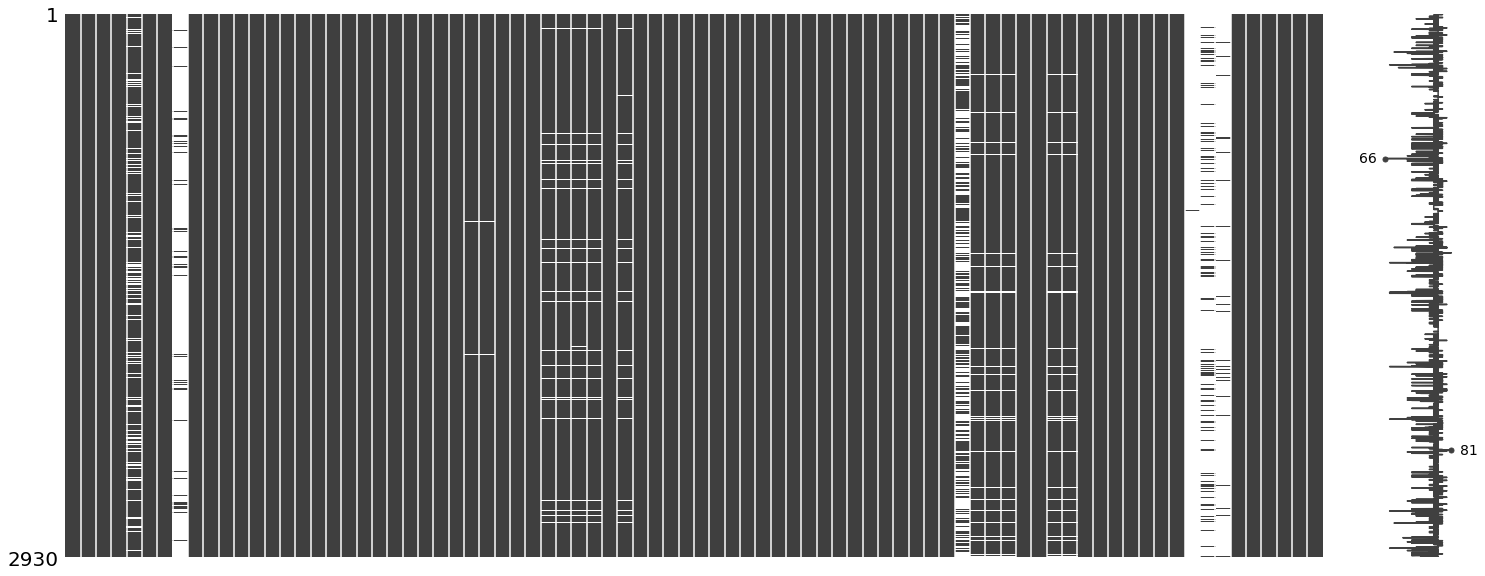

In [3]:
msno.matrix(df)
plt.show()

In [4]:
df = pd.read_csv('AmesHousing.tsv', delimiter="\t")
# lets create a dataset that, we're not going to use till the very end:
df_end_test = df[2000:]
# the remaining dataset will be split into 2 sets: train and test:
df = df[:2000]
train = df[:1000].copy()
test = df[1000:].copy()

In [5]:
df.isnull().sum().sort_values(ascending=False)[:10]

Pool QC          1995
Misc Feature     1918
Alley            1857
Fence            1616
Fireplace Qu      967
Lot Frontage      344
Garage Cond       104
Garage Finish     104
Garage Yr Blt     104
Garage Qual       104
dtype: int64

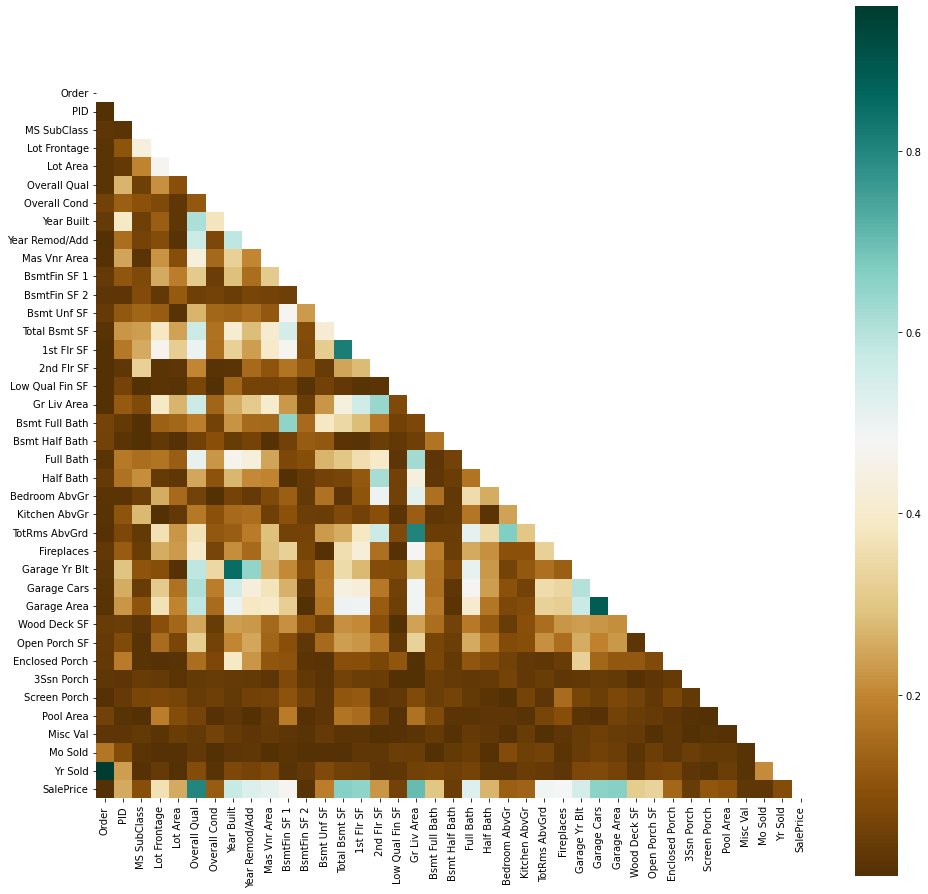

In [7]:
# lets generate a correlation heatmap:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(df.corr()), square=True, cmap='BrBG', mask=mask)
plt.show()

**Observations:**
* multiple columns with nominal or continuous data that can be merged into a smaller number of columns 
    * eg. there are at least 4 columns related to 'porch'
* some columns contain mostly null values (eg. Pool QC), we'll keep them for now and merge them into 1 column in the future
    * even though they're mostly empty, they may become an important factor in price predictions

# 2. setting up a basic pipeline

In [8]:
def transform_features2(df):
    # remove string columns with empty values:
    null_count = df.select_dtypes(include=['object']).isnull().sum()
    textic2_drop = null_count[null_count > 0].index
    df = df.drop(textic2_drop,axis=1) 
    # remove numeric columns with null values proportion higher than 5%
    null_count = (df.isnull().sum() / len(df))
    df = df[null_count[null_count<0.05].index]
    df = df.fillna(df.select_dtypes(include=['integer','float']).mean())

    # drop the year col and other data-leaky cols:
    cols_to_drop = ['Garage Yr Blt', "Year Remod/Add", 'Yr Sold', 'PID', "Order", 'Sale Type', 'Sale Condition',"Mo Sold"]
    for el in cols_to_drop:
        if el in df.columns:
            df = df.drop(el, axis = 1)
    return df

def select_features2(df_train, df_test):
    # check correlation of columns with SalePrice in TRAIN set (test set kind of "doesn't" have that column):
    abs_corr_coeffs = df_train.corr()['SalePrice'].abs().sort_values(ascending=False)
    # choose best(most correlated) columns in train set and trimm down both datasets to those columns:
    cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
    df_train = df_train[cols]
    df_test = df_test[cols]
    return df_train, df_test

def train_and_test(train, test): 
    # choose numeric columns:
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['integer','float'])
    
    # train
    features = numeric_train.columns.drop("SalePrice")
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    return rmse, predictions

# lets create a pipeline function, so  we can just replace names of the input functions to test out the new changes
def pipeline(df_train=train, df_test=test , t=transform_features2, s=select_features2, r=train_and_test):
    transform_train = t(df_train)
    transform_test = t(df_test)
    selected_train, selected_test = s(transform_train, transform_test)
    rmse, predictions = r(selected_train, selected_test)
    return rmse, predictions
r, p = pipeline()
r

38210.67417866206

# Improving feature selection and column dummies

In [37]:
def col_dummy(df, col):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes
    hood_series = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df, hood_series], axis=1)
    df = df.drop(columns=(col), axis=1)
    return df

categorical_no_leaks = [ "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature"]

categorical_no_leaks2 = []

# check which categorical columns have more than 10 value_counts, pass them on for hot encoding:
for col in categorical_no_leaks: 
    if (col in df.columns) & (df[col].value_counts().shape[0]>10):
        categorical_no_leaks2.append(col)

def select_features3(df_train,df_test, corr=0.1): 
    # check correlation of columns with SalePrice in TRAIN set (test set kind of "doesn't" have that column):   
    abs_corr_coeffs = df_train.corr()['SalePrice'].abs().sort_values(ascending=False)
     # choose best(most correlated) columns in train set and trimm down both datasets to those columns:
    cols = abs_corr_coeffs[abs_corr_coeffs > corr].index.tolist()
    df_train2 = df_train[cols].copy()
    df_test2 = df_test[cols].copy()
    #hot encoding:
    for col in categorical_no_leaks2:
        if col in df.columns:
            df_train2[col] = df_train[col]
            df_test2[col] = df_test[col]           
            df_train2 = col_dummy(df_train,col)
            df_test2 = col_dummy(df_test,col)         
    return df_train, df_test

r, p = pipeline(df_train=train, df_test=test, s=select_features3)
r

36854.046594920386

In [10]:
def spines(ax,yl='Price',xl='Gr Liv Area',title='No title!'):
    x1 = ax.spines['right'].set_visible(False)
    x2 = ax.spines['top'].set_visible(False)
    x3 = ax.spines['left'].set_linewidth(2)
    x4 = ax.spines['bottom'].set_linewidth(2)
    x5 = ax.set_ylabel(yl)
    x6 = ax.set_xlabel(xl)
    x7 = ax.set_title(title)
    return x1, x2, x3, x4, x5, x6

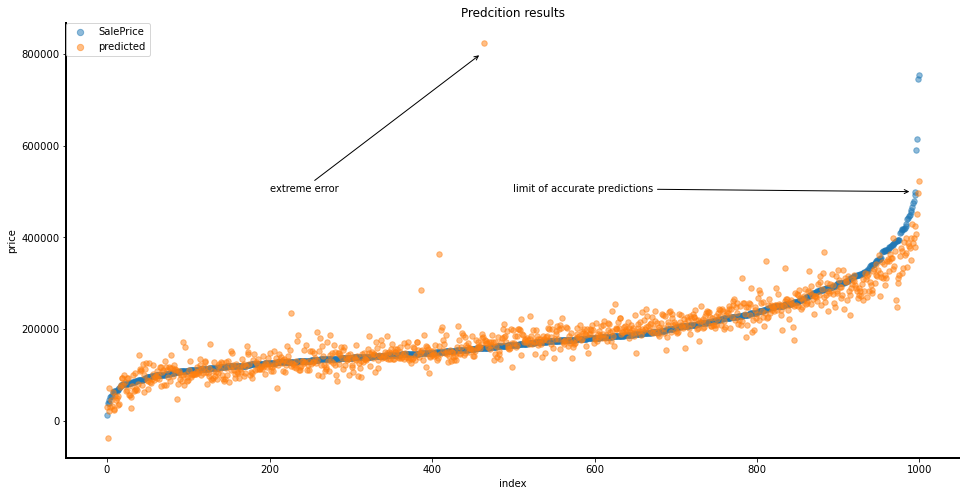

In [41]:
test['predicted'] = p
test = test.sort_values('SalePrice')
test = test.reset_index()
test = test.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(test.index, test['SalePrice'], s=30, label='SalePrice', alpha=0.5)
plt.scatter(test.index, test['predicted'], s=30, label='predicted', alpha=0.5)
spines(ax,yl='price',xl='index')
plt.title('Predcition results')
# plt.legend()
ax.annotate("extreme error", xy=(460, 800000), xytext=(200, 500000), arrowprops=dict(arrowstyle="->"))
ax.annotate("limit of accurate predictions", xy=(990, 500000), xytext=(500, 500000), arrowprops=dict(arrowstyle="->"))



handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.show()

**Observations:**
* 1 very big and extreme error is having a huge impact on our rmse results
* we can notice, that towards the right side of chart, as the price increses, the prediction values can't keep up with the price icrease 

In [12]:
test.sort_values('predicted',ascending=False)[:1]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,predicted
464,1499,908154235,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,...,Gd,NaN,NaN,0,1,2008,New,Partial,160000,824829.99499


In [13]:
abs_corr_coeffs = train.corr()['SalePrice'].abs().sort_values(ascending=False)
cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()

In [14]:
test[cols].loc[464] / test[cols].mean()

SalePrice          0.860035
Overall Qual       1.609788
Gr Liv Area        3.730231
Total Bsmt SF      5.698988
1st Flr SF         4.012472
Garage Cars        1.111111
Garage Area        2.947412
Year Built         1.017819
Garage Yr Blt      1.014351
Year Remod/Add     1.011070
Full Bath          1.253133
BsmtFin SF 1      12.700087
Mas Vnr Area       6.827161
TotRms AbvGrd      1.859600
Fireplaces         5.110733
dtype: float64

1 extreme prediction results in a very big increase of a rmse results

# Outlier removal

RMSE results:
IQR:  27414.72052922669     Z score:  28277.375376245913


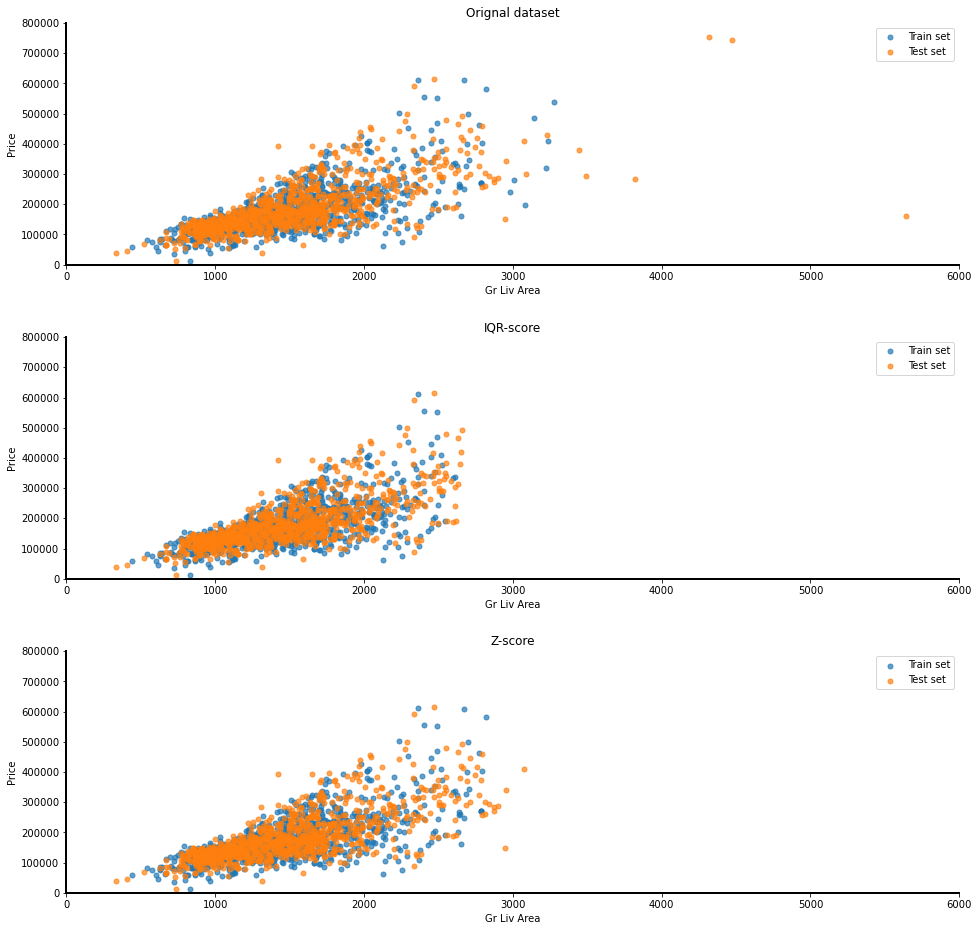

In [15]:
train = df[:1000].copy()
test = df[1000:].copy()

def iqring(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[~((df[col] < (Q1 - 1.5 * IQR)) |(df[col] > (Q3 + 1.5 * IQR)))]
    return df2

# IQR
train_iqr = iqring(train,'Gr Liv Area' )
test_iqr = iqring(test,'Gr Liv Area' )

# Z score
z = np.abs(stats.zscore(train['Gr Liv Area']))
threshold = 3
np.where(z > 3)
train_z = train[(z < 3)]
z = np.abs(stats.zscore(test['Gr Liv Area']))
threshold = 3
np.where(z > 3)
test_z = test[(z < 3)]

iqr_rmse, p = pipeline(df_train=train_iqr, df_test=test_iqr, s=select_features3)
z_score_rmse, p = pipeline(df_train=train_z, df_test=test_z, s=select_features3)
print('RMSE results:')
print('IQR: ',iqr_rmse,'    Z score: ',z_score_rmse)

def scatter(df1, df2):
    x1 = plt.scatter(df1['Gr Liv Area'], df1['SalePrice'], s=25, alpha=0.7)
    x2 = plt.scatter(df2['Gr Liv Area'], df2['SalePrice'], s=25, alpha=0.7)
    plt.legend(['Train set','Test set'])
    return x1, x2

fig, ax = plt.subplots(figsize=(16,16))
grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)

ax1 = plt.subplot(grid[0, 0])
scatter(train, test)

ax2 = plt.subplot(grid[1, 0])
scatter(train_iqr, test_iqr)

ax3 = plt.subplot(grid[2, 0])
scatter(train_z, test_z)

spines(ax1, title='Orignal dataset'), spines(ax2, title='IQR-score'), spines(ax3, title='Z-score')
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0,6000)
    ax.set_ylim(0,800000)
plt.show()

In [16]:

original_results = []
iqr_results = []
z_results = []
df2 = df.copy()
for num in list(range(1,11)):
    np.random.seed(num)
    shuffled_index = np.random.permutation(df2.index)
    df2 = df2.reindex(index = shuffled_index)
    split_loc = int(0.5*len(df2))
    # split
    train_rand = df2.iloc[:split_loc].copy()
    test_rand  = df2.iloc[split_loc:].copy()
    train_iqr = iqring(train_rand,'Gr Liv Area' )
    test_iqr = iqring(test_rand,'Gr Liv Area' )

    # Z score
    z = np.abs(stats.zscore(train_rand['Gr Liv Area']))
    threshold = 3
    np.where(z > 3)
    train_z = train_rand[(z < 3)]
    z = np.abs(stats.zscore(test_rand['Gr Liv Area']))
    threshold = 3
    np.where(z > 3)
    test_z = test_rand[(z < 3)]

    rmse, p = pipeline(df_train=train_rand, df_test=test_rand, s=select_features3)
    original_results.append(rmse)
    iqr_rmse, p = pipeline(df_train=train_iqr, df_test=test_iqr, s=select_features3)
    iqr_results.append(iqr_rmse)
    z_score_rmse, p = pipeline(df_train=train_z, df_test=test_z, s=select_features3)
    z_results.append(z_score_rmse)

In [17]:
nums = list(range(1,11))

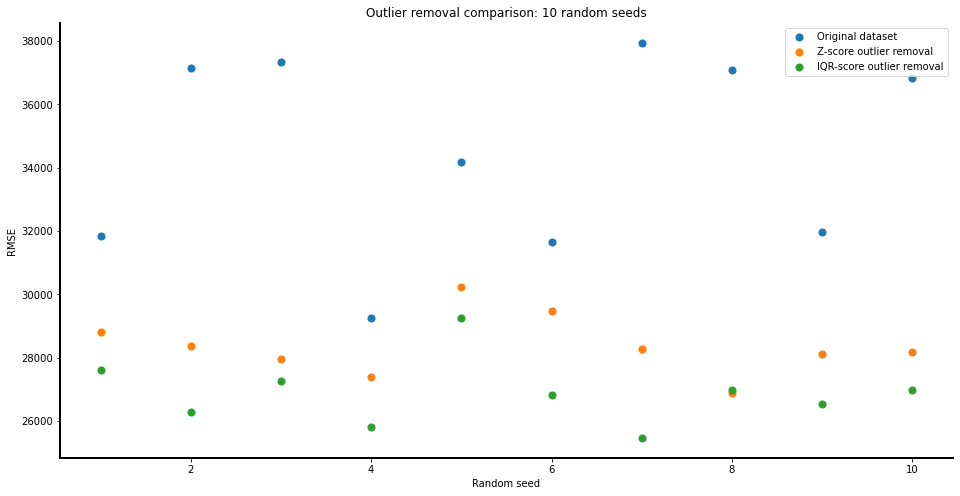

In [49]:
fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(nums, original_results, label='Original dataset', s=50)
plt.scatter(nums, z_results, label='Z-score outlier removal', s=50)
plt.scatter(nums, iqr_results, label='IQR-score outlier removal', s=50)
spines(ax,xl='Random seed', yl='RMSE', title='Outlier removal comparison: 10 random seeds')
plt.legend()
plt.show()

In [50]:
print('Original dataset avg rmse results:',np.mean(original_results))
print('Dataset with z-score outlier removal:', np.mean(z_results))
print('Dataset with iqr-score outlier removal:',np.mean(iqr_results))

Original dataset avg rmse results: 34520.38303004007
Dataset with z-score outlier removal: 28366.63298514278
Dataset with iqr-score outlier removal: 26895.80625874908


In [52]:
len(train)

1000

In [51]:
len(train_iqr)

979

**IQR score generates the best results.**
* We'll continue on with removing outliers using IQR score method. 
* It's worth remembering that every round of outlier removal reduces the size of the dataset.

# 3.1. Feature engineering part 1.
At this stage we'll commence an art of subtle engineering, the best guidance I've found online is a [post](https://towardsdatascience.com/feature-engineering-and-ensembled-models-for-the-top-10-in-kaggle-housing-prices-competition-efb35828eef0) made by one of the top kagglers. To quote a very important section from his post:

>Combining data / simplifying the model — that’s what I use a lot. The world is not that complicated. In this case, it seems to me that 3 features would be enough — how big the house is?, how nice it is? how comfortable is it?

(The above link leads to an article on towardsdatascience.com, link to original post: [link](https://www.kaggle.com/c/home-data-for-ml-course/discussion/100526#652503))

Combining data seems like an easy option - lets try it. We'll merge columns in a few different ways, for now lets start with an easy merging of features and their quality. We can see a repetitive pattern in some columns:
* numeric column with amount(or area) of features (eg. number of kitchens or garage area)
* categorical column with quality of features (quality scale: 'Po', 'Fa', 'TA', 'Gd', 'Ex')
* we'll transform the quality column into numbers and multiply it by the amount of features
    * while doing that will raise the quality number to a power of our own deciding (the idea is: quality of kitchen should be more important and price influencing than the quality of garage) 

In [19]:
def quality_area(data2,phrase,col1,col2, weight):
    # look up all 'keyword' columns:
    phrase_cols = [col for col in data2.columns if phrase in col]
    data2['quality'] = data2[col1].map({None: 1, "Po": 2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    # change nulls to 1:
    data2.loc[data2["quality"].isnull(), "quality"] = 1
    data2[phrase+'_all'] = data2[col2] * (data2["quality"]**weight)
    data2 = data2.drop(columns=phrase_cols+["quality"], axis=1)
    return data2

def merge_cols(df):
    # Now lets use this function to merge all columns that relate to:
    # 1. fireplace
    df = quality_area(df,'Fireplace','Fireplace Qu','Fireplaces',5)
    # 2. kitchen:
    df = quality_area(df,'Kitchen','Kitchen Qual','Kitchen AbvGr',7)
    # 3. garage
    df = quality_area(df,'Garage','Garage Cond','Garage Area',1)
#     4. pool and... - lets try adding one more column to 'Pool_all' column
    df = quality_area(df,'Pool','Pool QC','Pool Area',1)
    df['Pool_all'] = df['Pool_all']+df['Misc Val']
    df = df.drop(columns=['Misc Val'])
    return df

train = df[:1000].copy()
test = df[1000:].copy()
train = iqring(train,'Gr Liv Area' )
test = iqring(test,'Gr Liv Area' )
train = merge_cols(train)
test = merge_cols(test)
iqr_rmse, p = pipeline(df_train=train, df_test=test, s=select_features3)
iqr_rmse

25716.60076718674

In [20]:
def merge_cols2(df):
    # bathrooms:
    df['bath_count'] = df['Full Bath']**3 + (df['Half Bath']) + df['Bsmt Full Bath'] + df['Bsmt Half Bath']
    df = df.drop(columns=['Full Bath', 'Half Bath', 'Bsmt Full Bath', 'Bsmt Half Bath'], axis=1)

    # porch
    porch_cols = [col for col in df.columns if 'Porch' in col]
    df['total_porch'] = df[porch_cols].sum(axis=1) + df['Wood Deck SF']
    df= df.drop(columns=porch_cols+['Wood Deck SF'], axis=1)

    df['livin_qa'] = (df['Gr Liv Area'] ) * (df["Overall Qual"]) 
    df = df.drop(columns=['Gr Liv Area',"Overall Qual"], axis=1)
    lot_cols = [col for col in df.columns if 'Lot' in col]

    df= df.drop(columns=lot_cols, axis=1)
    return df

train = df[:1000].copy()
test = df[1000:].copy()
train = iqring(train,'Gr Liv Area' )
test = iqring(test,'Gr Liv Area' )
train = merge_cols(train)
test = merge_cols(test)
train = merge_cols2(train)
test = merge_cols2(test)

rmse, p = pipeline(df_train=train, df_test=test, s=select_features3)
rmse

24084.738986915392

# 3.2. Feature engineering part 2.

After doing the first part of feature engineering our rmse results lowered - we're on the right track. We'll continue with a modified approach. General idea stays the same: merge multiple columns related to the same topic into 1 column (call it captain planet). However it gets a bit trickier at this stage:

* they're categorical columns so we can't just add or multiply their values
* instead we'll group the dataset by the current column(eg.'Roof Style') and get average house price values per roof style
    * we'll do the same for every 'roof' column
    * then we'll either add or multiply all those values to create one unified 'roof' column
    * we'll repeat the process for other features
    * it's important to pay attention to type of columns - mapping columns with continuos values would create data leaks

In [21]:
categorical_no_leaks2 = ['MS SubClass', 'Neighborhood']

def merging_data(df,cols_list):
    d_list = []
    for el in cols_list:
        d = df.groupby(el)['SalePrice'].mean().sort_values().to_dict()
        d_list.append(d)
    return d_list, cols_list

def merge_cols3(train, test):

    # Roof: 
    dl,dl1 = merging_data(train, ['Roof Style', 'Roof Matl'])
    train['roofs'] = train['Roof Style'].map(dl[0]) + train['Roof Matl'].map(dl[1])**2
    test['roofs'] = test['Roof Style'].map(dl[0]) + test['Roof Matl'].map(dl[1])**2
    
    # street: 
    dl,dl2 = merging_data(train, ['Street', 'Alley', 'Paved Drive'])
    train['streets'] = train['Street'].map(dl[0]) + train['Alley'].map(dl[1]) + train['Paved Drive'].map(dl[2])
    test['streets'] = test['Street'].map(dl[0]) + test['Alley'].map(dl[1]) + test['Paved Drive'].map(dl[2])
   
    # basement:
    dl,dl3 = merging_data(train, ['Bsmt Qual','Bsmt Exposure','Bsmt Cond'])
    train['base_all'] = (train['Bsmt Qual'].map(dl[0]) + train['Bsmt Exposure'].map(dl[1]) + train['Bsmt Cond'].map(dl[2])) * train['Total Bsmt SF']
    test['base_all'] = (test['Bsmt Qual'].map(dl[0]) + test['Bsmt Exposure'].map(dl[1]) + test['Bsmt Cond'].map(dl[2])) * test['Total Bsmt SF']
   
    # exterior:
    dl,dl4 = merging_data(train, ['Exter Qual', 'Exter Cond', 'Exterior 1st', 'Exterior 2nd', 
                                'Mas Vnr Type', 'Foundation'])
    train['exterior'] = (train['Exter Qual'].map(dl[0])*2 + train['Exter Cond'].map(dl[1]) + train['Exterior 1st'].map(dl[2]) 
    + train['Exterior 2nd'].map(dl[3]) + train['Foundation'].map(dl[5]) + train['Mas Vnr Type'].map(dl[4])) * train['Mas Vnr Area']  
    test['exterior'] = (test['Exter Qual'].map(dl[0])*2 + test['Exter Cond'].map(dl[1]) + test['Exterior 1st'].map(dl[2]) 
    + test['Exterior 2nd'].map(dl[3]) + test['Foundation'].map(dl[5]) + test['Mas Vnr Type'].map(dl[4])) * test['Mas Vnr Area']  
    
    # heating, AC
    dl, dl5 = merging_data(train, ['Heating', 'Heating QC', 'Central Air'])
    train['heating'] = train['Heating'].map(dl[0]) + train['Heating QC'].map(dl[1]) + train['Central Air'].map(dl[2])
    test['heating'] = test['Heating'].map(dl[0]) + test['Heating QC'].map(dl[1]) + test['Central Air'].map(dl[2])
    
    land_cols = [col for col in df.columns if 'Land' in col]
    dl,dl6 = merging_data(train, land_cols)
    train['land_all'] = train[land_cols[0]].map(dl[0]) + train[land_cols[1]].map(dl[1])
    test['land_all'] = test[land_cols[0]].map(dl[0]) + test[land_cols[1]].map(dl[1])

    train = train.drop(columns=dl1 + dl2 + dl3 + dl4 + dl5 + dl6 + ['Mas Vnr Area', 'Total Bsmt SF' ])
    test = test.drop(columns=dl1 + dl2 + dl3 + dl4 + dl5 + dl6 + ['Mas Vnr Area', 'Total Bsmt SF' ])
    return train, test

train = df[:1000].copy()
test = df[1000:].copy()
train = iqring(train,'Gr Liv Area' )
test = iqring(test,'Gr Liv Area' )
train = merge_cols(train)
test = merge_cols(test)
train = merge_cols2(train)
test = merge_cols2(test)
train, test = merge_cols3(train, test)
rmse, p = pipeline(df_train=train, df_test=test, s=select_features3)
rmse

22654.03815744211

# The noise

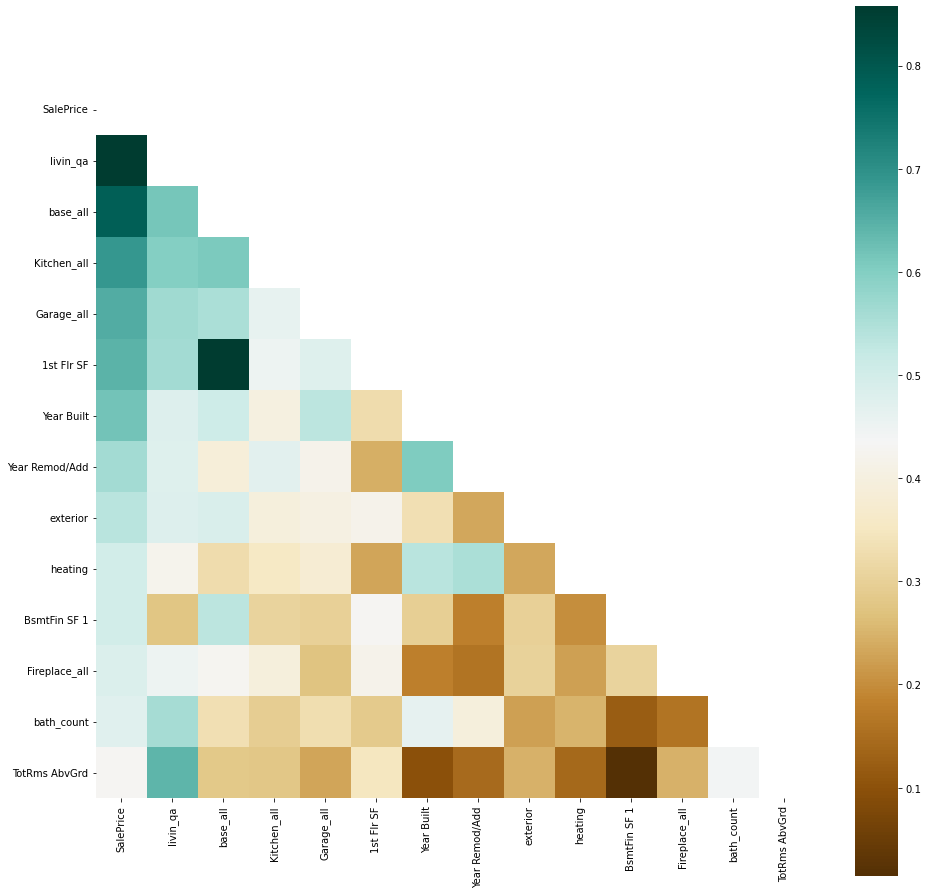

In [22]:
abs_corr_coeffs = train.corr()['SalePrice'].abs().sort_values(ascending=False)
cols = abs_corr_coeffs[abs_corr_coeffs > 0.4].index.tolist()
# lets generate a correlation heatmap:
mask = np.triu(np.ones_like(train[cols].corr(), dtype=bool))
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(abs(train[cols].corr()), square=True, cmap='BrBG', mask=mask)
plt.show()

In [23]:
def dropem(df1,df2, cols):
    df1 = df1.drop(columns=cols)
    df2 = df2.drop(columns=cols)
    return df1, df2

train = df[:1000].copy()
test = df[1000:].copy()
train = iqring(train,'Gr Liv Area' )
test = iqring(test,'Gr Liv Area' )
train = merge_cols(train)
test = merge_cols(test)
train = merge_cols2(train)
test = merge_cols2(test)
train, test = merge_cols3(train, test)

cols = ['TotRms AbvGrd', 'Year Remod/Add']
train, test = dropem(train, test, cols)

train = iqring(train,'livin_qa' )
test = iqring(test,'livin_qa' )

train = iqring(train,'BsmtFin SF 1' )
test = iqring(test,'BsmtFin SF 1' )

train = iqring(train,'1st Flr SF' )
test = iqring(test,'1st Flr SF' )

rmse, p = pipeline(df_train=train, df_test=test, s=select_features3)
rmse

21436.11201687847

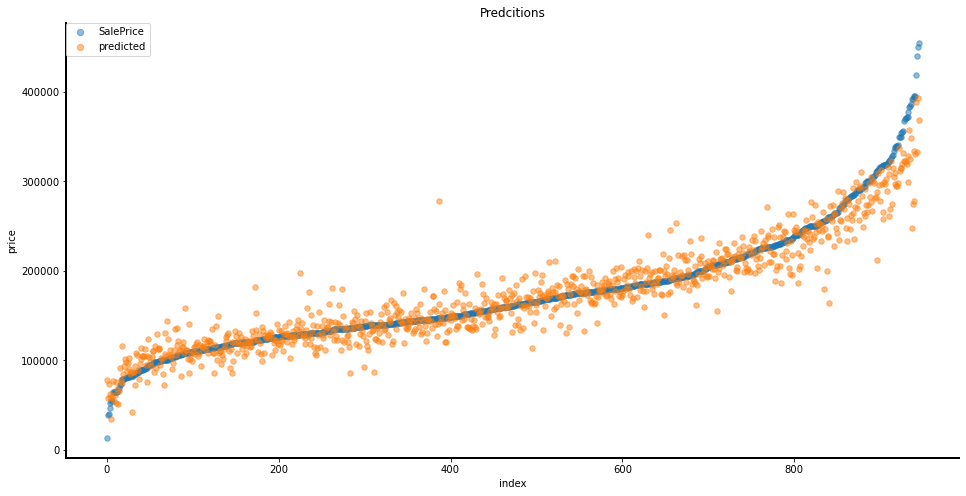

In [24]:
test['predicted'] = p
test = test.sort_values('SalePrice')
test = test.reset_index()
test = test.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(test.index, test['SalePrice'], s=30, alpha=0.5, label='SalePrice')
plt.scatter(test.index, test['predicted'], s=30, alpha=0.5, label='predicted')
spines(ax,yl='price',xl='index')
plt.title('Predcitions')
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.show()

In [27]:
train = df.copy()
test = df_end_test.copy()

train = iqring(train,'Gr Liv Area' )
test = iqring(test,'Gr Liv Area' )
train = merge_cols(train)
test = merge_cols(test)
train = merge_cols2(train)
test = merge_cols2(test)
train, test = merge_cols3(train, test)

cols = ['TotRms AbvGrd', 'Year Remod/Add']
train, test = dropem(train, test, cols)

train = iqring(train,'livin_qa' )
test = iqring(test,'livin_qa' )

train = iqring(train,'BsmtFin SF 1' )
test = iqring(test,'BsmtFin SF 1' )

train = iqring(train,'1st Flr SF' )
test = iqring(test,'1st Flr SF' )

rmse, p = pipeline(df_train=train, df_test=test, s=select_features3)
rmse

20264.81864117655

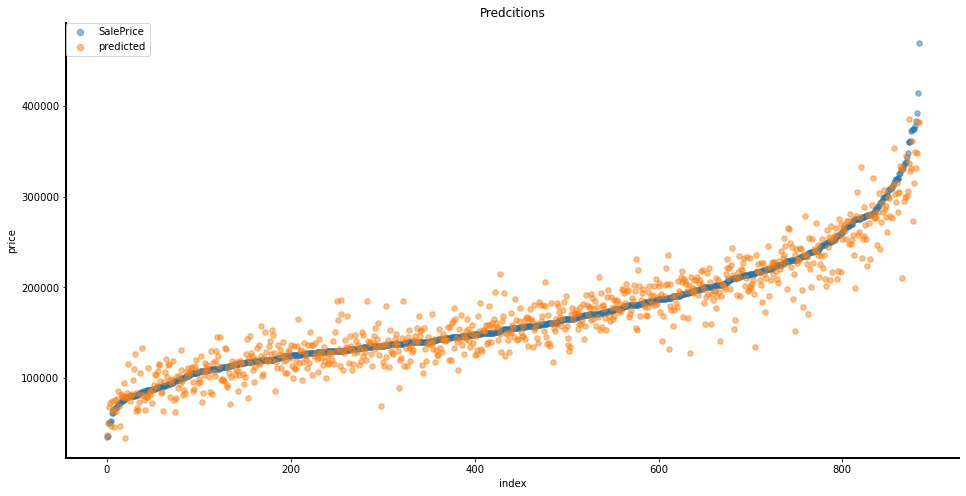

In [28]:
test['predicted'] = p
test = test.sort_values('SalePrice')
test = test.reset_index()
test = test.drop(columns='index')

fig, ax = plt.subplots(figsize=(16,8))
plt.scatter(test.index, test['SalePrice'], s=30, alpha=0.5, label='SalePrice')
plt.scatter(test.index, test['predicted'], s=30, alpha=0.5, label='predicted')
spines(ax,yl='price',xl='index')
plt.title('Predcitions')
# plt.legend()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles, labels, loc=2, borderaxespad=0)
for el in l.legendHandles:
    el._sizes = [40]
plt.show()